# L13 RNN Classifier

In [1]:
import torch
from torch import nn
import numpy as np

BATCH_SIZE = 256
HIDDEN_SIZE = 100
N_LAYER = 2
N_EPOCH = 20
N_CHAR = 128
USE_GPU = False
DEVICE = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu")

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gzip
import csv

class NameDataset(Dataset):
    def __init__(self, is_train=True):
        filename = 'dataset/names_train.csv.gz' if is_train else 'dataset/names_test.csv.gz'
        with gzip.open(filename, "rt") as f:
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.countries = [row[1] for row in rows]
        self.len = len(self.names)
        self.countryList = list(sorted(set(self.countries)))
        self.countryDict = self.getCountryDict()
        self.countryNum = len(self.countryList)
        
    def __getitem__(self, index):
        return self.names[index], self.countryDict[self.countries[index]]
    
    def __len__(self):
        return self.len
    
    def getCountryDict(self):
        countryDict = dict()
        for idx, country_name in enumerate(self.countryList):
            countryDict[country_name] = idx
        return countryDict
    
    def idx2country(self, idx):
        return self.countryList[idx]
    
    def getCountriesNum(self):
        return self.countryNum
    
trainset = NameDataset(is_train=True)
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testset = NameDataset(is_train=False)
testLoader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

N_COUNTRY = trainset.getCountriesNum()

In [3]:
def name2list(name):
    seq = [ord(c) for c in name]
    # print("names ", np.array(seq).shape)
    return seq, len(seq)

def makeTensors(names, countries):
    # get name seq & len
    seq_and_len = [name2list(name) for name in names]
    name_seq = [s[0] for s in seq_and_len]
    name_len = torch.LongTensor([s[1] for s in seq_and_len])
    countries = countries.long()
    # print("names ", np.array(seq_and_len).shape, np.array(name_seq).shape, np.array(name_len).shape)
    
    # BatchSize x SeqLen
    seq_tensor = torch.zeros(len(name_seq), name_len.max()).long()
    for idx, (cur_seq, cur_len) in enumerate(zip(name_seq, name_len), 0):
        seq_tensor[idx, :cur_len] = torch.LongTensor(cur_seq)
    # print("seq_tensor ", seq_tensor.shape)
        
    # sort by len to use pack_padded_sequence
    name_len, indices = name_len.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[indices]
    countries = countries[indices]
    # print("name_len ", np.array(name_len).shape, " indices ", np.array(indices).shape)
    # print("seq_tensor ", seq_tensor.shape)
    # print("countries ", countries.shape)
    
    # print(seq_tensor.shape, name_len.shape, countries.shape)
    return seq_tensor.to(DEVICE), name_len.to(DEVICE), countries.to(DEVICE)

In [4]:
from torch.nn.utils.rnn import pack_padded_sequence

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layer=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layer = n_layer
        self.n_direction = 2 if bidirectional else 1
        
        self.emb = nn.Embedding(input_size, hidden_size) # (seqLen, batchSize) -> (seqLen, batchSize, hiddenSize)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layer, bidirectional=bidirectional)
        # input:(seqLen, batchSize, hiddenSize)
        # hidden:(n_layer*n_direction, batchSize, hiddenSize)
        # output:(seqLen, batchSize, hiddenSize*n_direction)
        self.fc = nn.Linear(hidden_size * self.n_direction, output_size)
        return
    
    def forward(self, input, seq_lens):
        input = input.T # B x S -> S x B 
        # print(input.shape)
        batch_size = input.shape[1]
        hidden = self._init_hidden(batch_size)
        
        embedding = self.emb(input)
        gru_input = pack_padded_sequence(embedding, seq_lens) # pack up
        out, hidden = self.gru(gru_input, hidden)
        if self.n_direction == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_out = self.fc(hidden_cat)
        return fc_out
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layer * self.n_direction, batch_size, self.hidden_size)
        return hidden.to(DEVICE)

In [5]:
import math
def time_since(start):
    s = time.time() - start
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" %(m, s)

def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainLoader, 1):
        inputs, name_lens, target = makeTensors(names, countries)
        # print(inputs.shape, name_lens.shape, target.shape)
        output = classifier(inputs, name_lens)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end="")
            print(f'[{i * len(inputs)}/{len(trainset)}] ', end="")
            print('loss=%.3f' %(total_loss / (i * len(inputs))))
                      
    return total_loss

In [6]:
def testModel(testloader):
    correct = 0
    total = len(testset)
    print("evaluating trained model...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, name_lens, target = makeTensors(names, countries)
            output = classifier(inputs, name_lens)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        percent = '%.2f' % (100 * correct / total)
        print(f'Dev set: Accuracy {correct}/{total} {percent}%')
        
    return correct / total

In [7]:
import time

classifier = RNNClassifier(N_CHAR, HIDDEN_SIZE, N_COUNTRY, N_LAYER).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

start = time.time()
print("Training for %d epochs..." % N_EPOCH)
loss_list = []
acc_list = []
for epoch in range(1, N_EPOCH+1):
    loss = trainModel()
    loss_list.append(loss)
    acc = testModel(testLoader)
    acc_list.append(acc)

print("Accurate rate in testset: ", testModel(testLoader))

Training for 20 epochs...
 1s] Epoch 1 [2560/13374] loss=0.009
 3s] Epoch 1 [5120/13374] loss=0.008
 4s] Epoch 1 [7680/13374] loss=0.007
 6s] Epoch 1 [10240/13374] loss=0.007
 8s] Epoch 1 [12800/13374] loss=0.006
evaluating trained model...
Dev set: Accuracy 4466/6700 66.66%
 10s] Epoch 2 [2560/13374] loss=0.004
 12s] Epoch 2 [5120/13374] loss=0.004
 13s] Epoch 2 [7680/13374] loss=0.004
 15s] Epoch 2 [10240/13374] loss=0.004
 17s] Epoch 2 [12800/13374] loss=0.004
evaluating trained model...
Dev set: Accuracy 4994/6700 74.54%
 19s] Epoch 3 [2560/13374] loss=0.003
 21s] Epoch 3 [5120/13374] loss=0.003
 22s] Epoch 3 [7680/13374] loss=0.003
 24s] Epoch 3 [10240/13374] loss=0.003
 26s] Epoch 3 [12800/13374] loss=0.003
evaluating trained model...
Dev set: Accuracy 5250/6700 78.36%
 28s] Epoch 4 [2560/13374] loss=0.003
 30s] Epoch 4 [5120/13374] loss=0.003
 31s] Epoch 4 [7680/13374] loss=0.003
 33s] Epoch 4 [10240/13374] loss=0.003
 35s] Epoch 4 [12800/13374] loss=0.003
evaluating trained mod

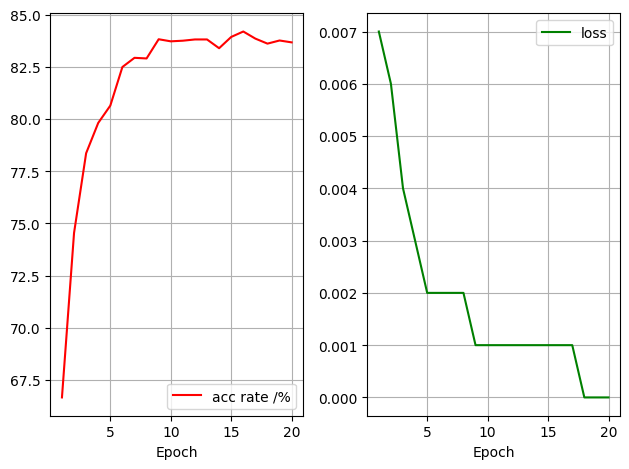

In [11]:
import matplotlib.pyplot as plt
import numpy as np

acc_list = [66.66, 74.54, 78.36, 79.81, 80.64, 82.49, 82.93, 82.90, 83.82, 83.72, 83.75, 83.81, 83.81, 83.39, 83.93, 84.19, 83.85, 83.61, 83.76, 83.67]
loss_list = [0.007, 0.006, 0.004, 0.003, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000, 0.000, 0.000]

epoch = np.arange(1, len(acc_list)+1, 1)
acc_list = np.array(acc_list)
loss_list = np.array(loss_list)

plt.subplot(121)
plt.plot(epoch, acc_list, "r-", label="acc rate /%")
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.grid()

plt.subplot(122)
plt.plot(epoch, loss_list, "g-", label="loss")
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()